The code replicates the Vision Tranfomer Paper named:

**An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale**

https://arxiv.org/abs/2010.11929

In [ ]:
# Import key libraries
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
import torch.random
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision.io import read_image

from PIL import Image

import shutil
import subprocess
from pathlib import Path
import os
import sys
from google.colab import drive
import requests
import zipfile
from timeit import default_timer as timer
import time
import random

from tqdm.auto import tqdm

from typing import List, Tuple, Dict, Optional, Union

import numpy as np

import matplotlib.pyplot as plt

import importlib

try:
  from torchinfo import summary
except:
  subprocess.run(["pip", "install", "torchinfo"],check=True)
  from torchinfo import summary

helper_function_path = "/content/Helper Functions"
if os.path.exists(helper_function_path):
  shutil.rmtree(helper_function_path)

URL = "https://github.com/anirguha/Python-2/raw/refs/heads/master/Helper%20Functions/copy_helper_functions.py"
code = requests.get(URL, timeout=30).text
exec(compile(code, URL, "exec"), {"__name__": "__main__"})

if os.path.exists("/content/Helper Functions"):
  for dirpath, dirnames, filenames in os.walk("/content/Helper Functions", topdown=True):
    sys.path.append(dirpath)
else:
  print("\u274c Error in loading Helper functions ")

import data_setup, engine, model_builder, utils, predict, icons

from helpers import download_data, set_seeds, plot_loss_curves



Copying folder to working directory ...
Cleaning up cloned repository ...
✅ Copy complete!
[INFO] Predicting on None


In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
image_url = "https://github.com/anirguha/Python-2/raw/refs/heads/master/Machine%20Learning%20Datasets/data/pizza_steak_sushi.zip"

dest = "pizza_steak_sushi"

if os.path.exists(dest):
  print(f"\u2705 {dest} already exists...skipping")
else:
  print(f"{icons.INFO} {dest} does not exists..adding")
  image_path = download_data(image_url, dest)

ℹ️ pizza_steak_sushi does not exists..adding
ℹ️ Did not find data/pizza_steak_sushi directory, creating one...
ℹ️ Downloading pizza_steak_sushi.zip from https://github.com/anirguha/Python-2/raw/refs/heads/master/Machine%20Learning%20Datasets/data/pizza_steak_sushi.zip...
ℹ️ Unzipping pizza_steak_sushi.zip data...


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

# Create DataLoaders

In [ ]:
# Transform the data
IMAGE_SIZE = (224,224)
transforms = v2.Compose([
    v2.Resize(IMAGE_SIZE),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [ ]:
# Create dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transforms,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    device=device
)

# Visualize a random sample image from train dataloader

In [ ]:
# Random select an image from the train dataloader
image_batch, label_batch = next(iter(train_dataloader))

idx_to_select = random.choice(torch.arange(len(image_batch)))

image, label = image_batch[idx_to_select],  label_batch[idx_to_select]

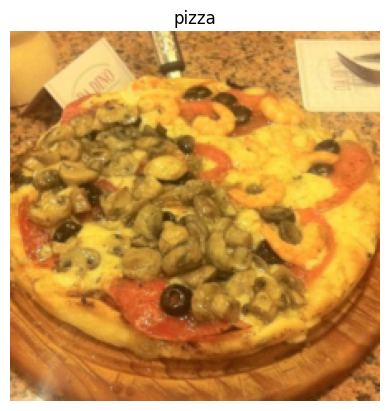

In [ ]:
# Display the image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

# Visualize the image into patches each of size 16x16

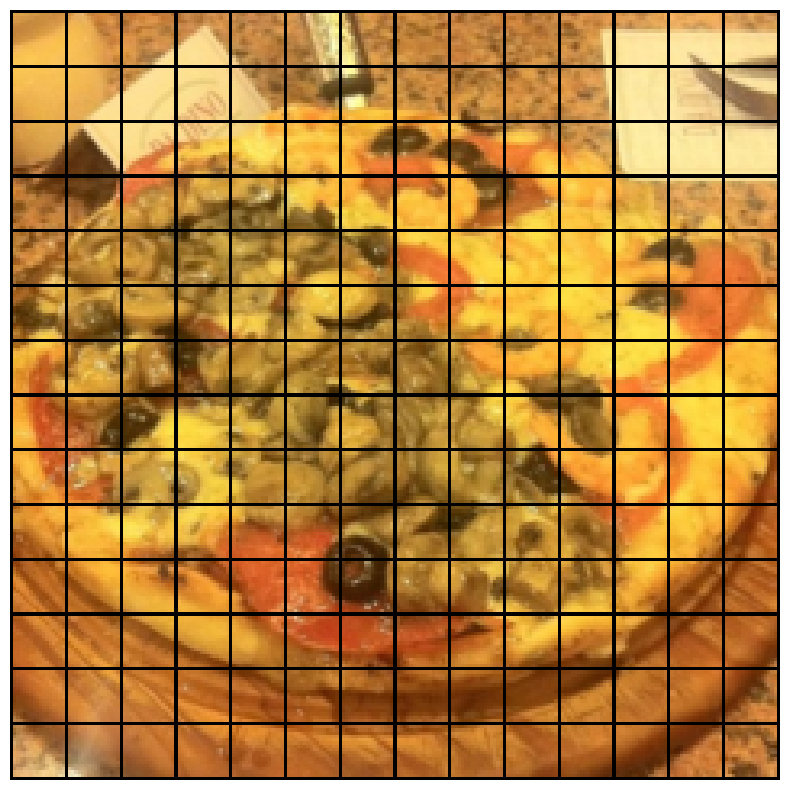

In [ ]:
# Faster way using PyTorch unfold and make_grid function
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

ps = 16
x = image.unsqueeze(0) # Add a batch dimension

# Get height and width from the image tensor
B, C, H, W = x.shape

patches = torch.nn.functional.unfold(x, kernel_size=ps, stride=ps)  # (1, 3*ps*ps, N)

B, _, N = patches.shape
patches = patches.view(B, C, ps, ps, N).permute(0,4,1,2,3).reshape(N, C, ps, ps)  # (N,3,ps,ps)

grid = make_grid(patches, nrow=W//ps, padding=1)  # padding draws 1px gaps
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0).cpu().numpy(), interpolation="nearest")
plt.axis("off")
plt.tight_layout()
plt.show()

# Define a class to create the patch embeddings

In [ ]:
class PatchEmbedding(nn.Module):
  """
  Creates a patch embedding layer
  Arguments:
  in_channel: int = number of input channels, provided by image.shape[0]
  path_size: int = size of the patch
  embedding_dim: int = number of embedding dimensions
  img: Optional[torch.Tensor] = image tensor, default: None
  use_cls_token: bool = whether to use a cls token, default: True
  Attributes:
  patch_size: int = size of the patch
  use_cls_token: bool = whether to use a cls token
  pos_embed: nn.Parameter = positional embedding
  conv2dproj: nn.Conv2d = convolution layer
  Output:
  x: torch.Tensor = patch embeddings
  """
  def __init__(self,
                in_channels: int,
                patch_size: int,
                embedding_dim: int,
                img: Optional[torch.Tensor] = None,
                use_cls_token: bool = True):
      super().__init__()
      self.patch_size = patch_size
      self.use_cls_token = use_cls_token

      self.conv2dproj = nn.Conv2d(in_channels,
                                  embedding_dim,
                                  kernel_size=patch_size,
                                  stride=patch_size,
                                  padding=0,
                                  bias=True)

      self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim)) if use_cls_token else None
      if self.cls_token is not None:
          nn.init.trunc_normal_(self.cls_token, mean=0, std=0.02)

      if img is not None:
          _, H, W = img.shape
          assert H % patch_size == 0 and W % patch_size == 0, \
              f"img_size must be divisible by patch_size (got H={H}, W={W}, P={patch_size})"
          n_patches = (H // patch_size) * (W // patch_size)
          n_tokens = n_patches + (1 if use_cls_token else 0)
          self.pos_embed = nn.Parameter(torch.randn(1, n_tokens, embedding_dim))
          nn.init.trunc_normal_(self.pos_embed, mean=0, std=0.02)
      else:
          self.pos_embed = None  # create or resize on forward

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = x.float()  # avoid Byte dtype issues
      B, C, H, W = x.shape
      p = self.patch_size
      assert H % p == 0 and W % p == 0, f"H={H}, W={W} must be divisible by patch_size={p}"

      # (B, E, H/P, W/P) -> (B, N, E)
      x = self.conv2dproj(x).flatten(2).transpose(1, 2)

      if self.use_cls_token:
          cls = self.cls_token.expand(B, -1, -1)    # (B, 1, E)
          x = torch.cat([cls, x], dim=1)            # (B, N+1, E)

      # Positional embeddings
      if self.pos_embed is None:
          # first-time lazy init to current length
          self.pos_embed = nn.Parameter(torch.randn(1, x.shape[1], x.shape[2], device=x.device, dtype=x.dtype))
          nn.init.trunc_normal_(self.pos_embed, mean=0, std=0.02)
      elif self.pos_embed.shape[1] != x.shape[1]:
          # safer behavior: interpolate or raise (choose one)
          raise ValueError(
              f"pos_embed length {self.pos_embed.shape[1]} != tokens {x.shape[1]} — "
              f"provide matching img_size or add interpolation."
          )

      return x + self.pos_embed  # (B, N(+1), E)


In [ ]:
patchify = PatchEmbedding(in_channels=3,
                          embedding_dim=768,
                          patch_size=16,
                          img=image)
image_patched_flattened = patchify(image.unsqueeze(0))

In [ ]:
image_patched_flattened, image_patched_flattened.shape

(tensor([[[-0.0212, -0.0112,  0.0206,  ..., -0.0138,  0.0170, -0.0263],
          [-0.2883,  0.3141, -0.3154,  ...,  0.0706,  0.6808,  0.4247],
          [-0.2978,  0.3049, -0.2456,  ...,  0.1430,  0.7099,  0.3294],
          ...,
          [-0.0814,  0.1073, -0.1236,  ..., -0.0386,  0.4251,  0.2761],
          [-0.3058,  0.1722, -0.2650,  ...,  0.0010,  0.4927,  0.3405],
          [-0.0998,  0.2005, -0.1560,  ...,  0.1405,  0.3724,  0.3503]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

# Create a Multi-Head Self Attention Block (MSA)

In [ ]:
class MultiHeadAttentionBlock(nn.Module):
    """
    Pre-norm multi-head *self*-attention block.

    Args:
        embedding_dim: Model/embedding dimension (E).
        num_heads: Number of attention heads (H). Must divide embedding_dim.
        dropout_p: Dropout probability applied to the attention output proj.
        batch_first: Inputs are (B, S, E) if True else (S, B, E).

    Inputs:
        x: Float tensor of shape (B, S, E) if batch_first else (S, B, E).
        attn_mask: Optional causal or custom mask of shape (S, S) or broadcastable.
        key_padding_mask: Optional bool of shape (B, S); True marks pads to ignore.
        need_weights: If True, returns average attention weights.

    Returns:
        y or (y, attn) where y has same shape as x.
    """
    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        dropout_p: float = 0.0,
        batch_first: bool = True,
        eps: float = 1e-5,
    ):
        super().__init__()
        assert embedding_dim % num_heads == 0, \
            f"embedding_dim ({embedding_dim}) must be divisible by num_heads ({num_heads})"

        self.batch_first = batch_first
        self.ln = nn.LayerNorm(embedding_dim, eps=eps)

        self.attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=dropout_p,          # attention-prob dropout
            batch_first=batch_first,
            bias=True
        )
        self.dropout = nn.Dropout(dropout_p)  # output-proj dropout

    def forward(
        self,
        x: torch.Tensor,
        *,
        attn_mask: Optional[torch.Tensor] = None,
        key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
        average_attn_weights: bool = True,
    ) -> torch.Tensor | Tuple[torch.Tensor, torch.Tensor]:

        residual = x
        x = self.ln(x)

        x, attn = self.attn(
            query=x, key=x, value=x,
            attn_mask=attn_mask,
            key_padding_mask=key_padding_mask,
            need_weights=need_weights,
            average_attn_weights=average_attn_weights
        )

        x = self.dropout(x)
        x = residual + x  # residual connection

        return (x, attn) if need_weights else x


In [ ]:
msa = MultiHeadAttentionBlock(embedding_dim=768,
                               num_heads=12)
msa_output = msa(image_patched_flattened)

In [ ]:
msa_output, msa_output.shape
#

(tensor([[[ 0.7129,  0.2857, -0.6345,  ...,  0.2382, -0.2062,  0.4364],
          [ 0.4475,  0.6060, -0.9728,  ...,  0.3262,  0.4589,  0.9009],
          [ 0.4386,  0.5962, -0.9031,  ...,  0.3974,  0.4876,  0.8055],
          ...,
          [ 0.6557,  0.3981, -0.7807,  ...,  0.2160,  0.2036,  0.7498],
          [ 0.4291,  0.4649, -0.9224,  ...,  0.2578,  0.2710,  0.8163],
          [ 0.6367,  0.4926, -0.8146,  ...,  0.3959,  0.1508,  0.8243]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
image_patched_flattened

tensor([[[-0.0212, -0.0112,  0.0206,  ..., -0.0138,  0.0170, -0.0263],
         [-0.2883,  0.3141, -0.3154,  ...,  0.0706,  0.6808,  0.4247],
         [-0.2978,  0.3049, -0.2456,  ...,  0.1430,  0.7099,  0.3294],
         ...,
         [-0.0814,  0.1073, -0.1236,  ..., -0.0386,  0.4251,  0.2761],
         [-0.3058,  0.1722, -0.2650,  ...,  0.0010,  0.4927,  0.3405],
         [-0.0998,  0.2005, -0.1560,  ...,  0.1405,  0.3724,  0.3503]]],
       grad_fn=<AddBackward0>)

# Create MultiLayer Perceptron Block

In [ ]:
import torch
from torch import nn

class MLPBlock(nn.Module):
    """
    Pre-norm feed-forward (MLP) block used in Transformer/ViT.

    Args:
        embedding_dim: Model/embedding dimension (E).
        mlp_size: Hidden size of the MLP. If None, defaults to mlp_ratio * E.
        mlp_ratio: Expansion ratio to compute mlp_size when mlp_size is None.
        dropout_p: Dropout probability applied within the MLP.
        eps: Epsilon for LayerNorm.
        activation: Activation module class (default: nn.GELU).
        drop_path: Stochastic depth prob (0.0 disables).

    Input:
        x: (B, S, E)

    Returns:
        y: (B, S, E)
    """
    def __init__(self,
                 embedding_dim: int,
                 mlp_size: int | None = None,
                 mlp_ratio: float = 4.0,
                 dropout_p: float = 0.1,
                 eps: float = 1e-5,
                 activation: type[nn.Module] = nn.GELU):
        super().__init__()
        hidden = mlp_size if mlp_size is not None else int(mlp_ratio * embedding_dim)

        self.ln = nn.LayerNorm(embedding_dim, eps=eps)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, hidden),
            activation(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden, embedding_dim),
            nn.Dropout(dropout_p),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        x = self.ln(x)
        x = self.mlp(x)
        return residual + x

In [ ]:
mlp = MLPBlock(embedding_dim=768)
mlp_output = mlp(msa_output)

In [ ]:
mlp_output, mlp_output.shape
#

(tensor([[[ 0.3547, -0.1569, -0.9928,  ...,  0.3668, -0.2062,  0.2823],
          [ 0.1386, -0.0078, -1.1968,  ...,  0.5821,  0.4746,  0.9325],
          [ 0.1084,  0.2890, -0.9929,  ...,  0.7128,  0.6105,  0.7222],
          ...,
          [ 0.5334, -0.1947, -1.1728,  ...,  0.2315,  0.2332,  0.7049],
          [ 0.4291, -0.0787, -1.1470,  ...,  0.6007,  0.3123,  0.7780],
          [ 0.4912, -0.0705, -1.0132,  ...,  0.6811,  0.2771,  0.7414]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

In [ ]:
msa_output

tensor([[[ 0.7129,  0.2857, -0.6345,  ...,  0.2382, -0.2062,  0.4364],
         [ 0.4475,  0.6060, -0.9728,  ...,  0.3262,  0.4589,  0.9009],
         [ 0.4386,  0.5962, -0.9031,  ...,  0.3974,  0.4876,  0.8055],
         ...,
         [ 0.6557,  0.3981, -0.7807,  ...,  0.2160,  0.2036,  0.7498],
         [ 0.4291,  0.4649, -0.9224,  ...,  0.2578,  0.2710,  0.8163],
         [ 0.6367,  0.4926, -0.8146,  ...,  0.3959,  0.1508,  0.8243]]],
       grad_fn=<AddBackward0>)

# Create a custom Tranformer Encoder Block

In [ ]:
class TransformerEncoderBlock(nn.Module):
    """
    Pre-norm transformer encoder block.

    Args:
        embedding_dim: Model/embedding dimension (E).
        num_heads: Number of attention heads (H). Must divide embedding_dim.
        mlp_size: Hidden size of the MLP.
        mlp_dropout: Dropout probability applied within the MLP (defualt: 0.1).
        attn_dropout: Dropout probability applied to the attention output(default: 0.0).
        batch_first: Inputs are (B, S, E) if True else (S, B, E) (default: True).
        eps: Epsilon for LayerNorm (default: 1e-5

    Inputs:
        x: Float tensor of shape (B, S, E) if batch_first else (S, B, E).

    Output:
        y: Float tensor of shape (B, S, E)

    """
    def __init__(self,
        embedding_dim: int,
        num_heads: int,
        mlp_size: int | None = None,
        mlp_droput: float = 0.1,
        attn_dropout: float = 0.0):

      super().__init__()

      self.msa = MultiHeadAttentionBlock(
        embedding_dim=embedding_dim,
        num_heads=num_heads,
        dropout_p=attn_dropout)

      self.mlp = MLPBlock(
        embedding_dim=embedding_dim,
        mlp_size=mlp_size,
        dropout_p=mlp_droput)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.msa(x) + x
      x = self.mlp(x) + x

      return x


In [ ]:
transformer_encoder = TransformerEncoderBlock(embedding_dim=768,
                                              num_heads=12,
                                              mlp_size=3072)

In [ ]:
# Get a summary of the model
summary(transformer_encoder,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])
#

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadAttentionBlock (msa)                    [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (ln)                              [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (attn)                   --                   [1, 197, 768]        2,362,368            True
│    └─Dropout (dropout)                           [1, 197, 768]        [1, 197, 768]        --                   --
├─MLPBlock (mlp)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (ln)                              [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                      

# Create Transformer Encoder Layer using PyTorch

In [ ]:
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                      nhead=12,
                                                      dim_feedforward=3072,
                                                      dropout=0.1, # Default
                                                      activation="gelu",#Default
                                                      batch_first=True,#Default
                                                      norm_first=True,#Default
                                                      bias=True,#Default
                                                      device=device,
                                                      dtype=torch.float32)

In [ ]:
# Get a summary of the model
summary(transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])
#

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

In [ ]:
img_transfomred = transformer_encoder_layer(image_patched_flattened.to(device))

In [ ]:
img_transfomred, img_transfomred.shape

(tensor([[[-1.9392e-02,  3.8888e-01,  1.9124e-01,  ...,  2.1135e-01,
            1.6186e-01,  9.8214e-01],
          [-5.2768e-02,  7.7722e-01, -4.3593e-02,  ...,  1.5026e-01,
            1.1960e+00,  1.5908e+00],
          [-3.1129e-01,  7.3150e-01,  3.5423e-02,  ...,  3.8138e-01,
            1.0464e+00,  1.4839e+00],
          ...,
          [ 3.8117e-01,  5.1289e-01,  1.3950e-01,  ...,  4.9364e-02,
            7.3484e-01,  1.1667e+00],
          [-7.3843e-02,  6.6105e-01, -6.7124e-03,  ...,  9.6877e-04,
            1.0976e+00,  1.5783e+00],
          [-6.5488e-02,  6.9390e-01,  3.3191e-01,  ...,  2.9897e-01,
            7.2641e-01,  1.5358e+00]]], device='cuda:0', grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

## Create a class for ViT model

In [ ]:
from __future__ import annotations

class PatchEmbedding(nn.Module):
    """
    Conv2d-based patch projection used in ViT-style models.

    Inputs:
        in_channels:   Input channels (e.g., 3 for RGB)
        patch_size:    Patch size (kernel=stride=patch_size)
        embedding_dim: Output embedding size per patch
        img:           Optional (C,H,W) example to precreate pos-embed length
        use_cls_token: Prepend a learnable [CLS] token if True
    """
    def __init__(self,
                 in_channels: int,
                 patch_size: int,
                 embedding_dim: int,
                 img: Optional[torch.Tensor] = None,
                 use_cls_token: bool = True):
        super().__init__()
        self.patch_size = patch_size
        self.use_cls_token = use_cls_token

        self.conv2dproj = nn.Conv2d(in_channels,
                                    embedding_dim,
                                    kernel_size=patch_size,
                                    stride=patch_size,
                                    padding=0,
                                    bias=True)

        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim)) if use_cls_token else None
        if self.cls_token is not None:
            nn.init.trunc_normal_(self.cls_token, mean=0.0, std=0.02)

        # Precreate positional embedding if img is given; else lazy-init in forward
        if img is not None:
            assert img.ndim == 3, "img must be (C,H,W)"
            _, H, W = img.shape
            assert H % patch_size == 0 and W % patch_size == 0, \
                f"img_size must be divisible by patch_size (H={H}, W={W}, P={patch_size})"
            n_patches = (H // patch_size) * (W // patch_size)
            n_tokens = n_patches + (1 if use_cls_token else 0)
            self.pos_embed = nn.Parameter(torch.randn(1, n_tokens, embedding_dim))
            nn.init.trunc_normal_(self.pos_embed, mean=0.0, std=0.02)
        else:
            self.pos_embed = None  # will be created on first forward

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.float()  # ensure float
        B, C, H, W = x.shape
        p = self.patch_size
        assert H % p == 0 and W % p == 0, f"H={H}, W={W} must be divisible by patch_size={p}"

        # (B, C, H, W) -> (B, E, H/P, W/P) -> (B, N, E)
        x = self.conv2dproj(x).flatten(2).transpose(1, 2)

        if self.use_cls_token:
            cls = self.cls_token.expand(B, -1, -1)  # (B,1,E)
            x = torch.cat([cls, x], dim=1)          # (B,N+1,E)

        # Positional embeddings (lazy init to the current token length)
        if self.pos_embed is None:
            self.pos_embed = nn.Parameter(torch.randn(1, x.shape[1], x.shape[2], device=x.device, dtype=x.dtype))
            nn.init.trunc_normal_(self.pos_embed, mean=0.0, std=0.02)
        elif self.pos_embed.shape[1] != x.shape[1]:
            raise ValueError(
                f"pos_embed length {self.pos_embed.shape[1]} != tokens {x.shape[1]} — "
                f"provide matching img_size or implement interpolation."
            )

        return x + self.pos_embed  # (B, N(+1), E)


class MultiHeadAttentionBlock(nn.Module):
    """
    Pre-norm multi-head self-attention block.
    Input/Output shape: (B, S, E) if batch_first=True. B=batch_size, S=seq_len, E=embedding_dim.
    """
    def __init__(self,
                 embedding_dim: int,
                 num_heads: int,
                 dropout_p: float = 0.0,
                 batch_first: bool = True,
                 eps: float = 1e-5):
        super().__init__()
        assert embedding_dim % num_heads == 0, \
            f"embedding_dim ({embedding_dim}) must be divisible by num_heads ({num_heads})"

        self.ln = nn.LayerNorm(embedding_dim, eps=eps)
        self.attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=dropout_p,
            batch_first=batch_first,
            bias=True
        )
        self.dropout = nn.Dropout(dropout_p)

    def forward(self,
                x: torch.Tensor,
                *,
                attn_mask: Optional[torch.Tensor] = None,
                key_padding_mask: Optional[torch.Tensor] = None,
                need_weights: bool = False,
                average_attn_weights: bool = True) -> torch.Tensor | Tuple[torch.Tensor, torch.Tensor]:
        residual = x
        x = self.ln(x)
        x, attn = self.attn(x, x, x,
                            attn_mask=attn_mask,
                            key_padding_mask=key_padding_mask,
                            need_weights=need_weights,
                            average_attn_weights=average_attn_weights)
        x = residual + self.dropout(x)
        return (x, attn) if need_weights else x


class MLPBlock(nn.Module):
    """Pre-norm MLP block with residual."""
    def __init__(self,
                 embedding_dim: int,
                 mlp_size: int | None = None,
                 mlp_ratio: float = 4.0,
                 dropout_p: float = 0.1,
                 eps: float = 1e-5,
                 activation: type[nn.Module] = nn.GELU):
        super().__init__()
        hidden = mlp_size if mlp_size is not None else int(mlp_ratio * embedding_dim)
        self.ln = nn.LayerNorm(embedding_dim, eps=eps)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, hidden),
            activation(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden, embedding_dim),
            nn.Dropout(dropout_p),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.mlp(self.ln(x))


class TransformerEncoderBlock(nn.Module):
    """One pre-norm Transformer encoder block."""
    def __init__(self,
                 embedding_dim: int,
                 num_heads: int,
                 mlp_size: int | None = None,
                 mlp_dropout: float = 0.1,
                 attn_dropout: float = 0.0):
        super().__init__()
        self.msa = MultiHeadAttentionBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            dropout_p=attn_dropout,
            batch_first=True
        )
        self.mlp = MLPBlock(
            embedding_dim=embedding_dim,
            mlp_size=mlp_size,
            dropout_p=mlp_dropout
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.msa(x)          # residual inside
        x = self.mlp(x)          # residual inside
        return x

    def to_device(self, device: str):
        self.to(device)


class ViTModel(nn.Module):
    """
    Minimal ViT-style classifier: PatchEmbed → N×Encoder → LN → CLS → Linear.
    """
    def __init__(self,
                 in_channels: int,
                 patch_size: int,
                 embedding_dim: int,
                 num_heads: int,
                 num_layers: int,
                 *,
                 img: Optional[torch.Tensor] = None,
                 num_classes: int = 1000,
                 mlp_dropout: float = 0.1,
                 attn_dropout: float = 0.0):
        super().__init__()

        self.patchify = PatchEmbedding(in_channels=in_channels,
                                       patch_size=patch_size,
                                       embedding_dim=embedding_dim,
                                       img=img,
                                       use_cls_token=True)

        self.encoder = nn.ModuleList([
            TransformerEncoderBlock(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                mlp_dropout=mlp_dropout,
                attn_dropout=attn_dropout
            ) for _ in range(num_layers)
        ])

        self.pre_head_ln = nn.LayerNorm(embedding_dim)
        self.head = nn.Linear(in_features=embedding_dim,
                              out_features=num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.patchify(x)          # (B, 1+N, E)

        # Offload encoder layers
        for layer in self.encoder:
            x = layer(x)
        x = self.pre_head_ln(x)       # (B, 1+N, E)
        cls = x[:, 0]                 # take [CLS] → (B, E)
        logits = self.head(cls)       # (B, C)
        return logits

In [ ]:
ViT = ViTModel(img=image,
               in_channels=3,
               patch_size=16,
               embedding_dim=768,
               num_heads=12,
               num_layers=12,
               num_classes=3).to(device)

In [ ]:
summary(model=ViT,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ViTModel (ViTModel)                                [1, 3, 224, 224]     [1, 3]               --                   True
├─PatchEmbedding (patchify)                        [1, 3, 224, 224]     [1, 197, 768]        152,064              True
│    └─Conv2d (conv2dproj)                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─ModuleList (encoder)                             --                   --                   --                   True
│    └─TransformerEncoderBlock (0)                 [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─MultiHeadAttentionBlock (msa)          [1, 197, 768]        [1, 197, 768]        2,363,904            True
│    │    └─MLPBlock (mlp)                         [1, 197, 768]        [1, 197, 768]        4,723,968            True
│    └─TransformerEncoderBlock (1)         

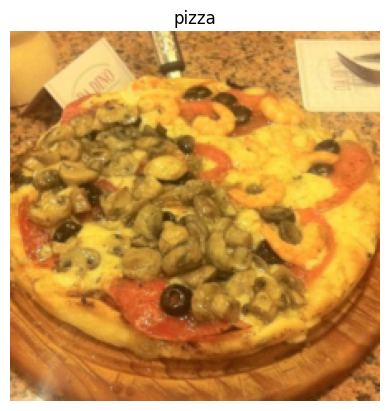

In [ ]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis("off");

In [ ]:
class_names[torch.argmax(ViT(image.unsqueeze(0).to(device)),dim=1)]

'steak'

# Train the model

In [ ]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(params=ViT.parameters(),
                             lr=0.001,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0.1,
                             amsgrad=False)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
from engine import train

results = train(model=ViT,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.9073 | train_acc: 39.8438 | test_loss: 2.5306 | test_acc: 26.0417
Epoch: 2 | train_loss: 1.6396 | train_acc: 30.4688 | test_loss: 1.0769 | test_acc: 54.1667
Epoch: 3 | train_loss: 1.6373 | train_acc: 28.9062 | test_loss: 2.1352 | test_acc: 19.7917
Epoch: 4 | train_loss: 1.8859 | train_acc: 29.2969 | test_loss: 1.0654 | test_acc: 54.1667
Epoch: 5 | train_loss: 1.3494 | train_acc: 26.9531 | test_loss: 1.0983 | test_acc: 54.1667
Epoch: 6 | train_loss: 1.2437 | train_acc: 28.5156 | test_loss: 1.2587 | test_acc: 26.0417
Epoch: 7 | train_loss: 1.4221 | train_acc: 26.9531 | test_loss: 1.1437 | test_acc: 54.1667
Epoch: 8 | train_loss: 1.3125 | train_acc: 35.1562 | test_loss: 1.2491 | test_acc: 19.7917
Epoch: 9 | train_loss: 1.3043 | train_acc: 26.5625 | test_loss: 1.3197 | test_acc: 26.0417
Epoch: 10 | train_loss: 1.2323 | train_acc: 31.2500 | test_loss: 1.0496 | test_acc: 54.1667


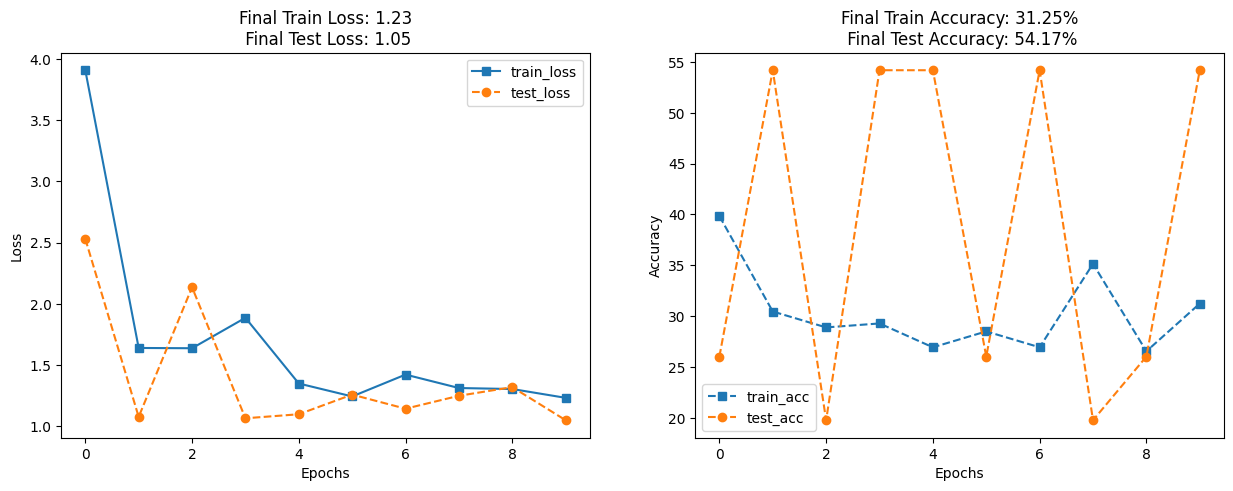

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(results["train_loss"],"s-",label="train_loss")
ax[0].plot(results["test_loss"],"o--",label="test_loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title(f"Final Train Loss: {results['train_loss'][-1]:.2f}\n Final Test Loss: {results['test_loss'][-1]:.2f}")
ax[0].legend()

ax[1].plot(results["train_acc"],"s--",label="train_acc")
ax[1].plot(results["test_acc"],"o--",label="test_acc")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title(f"Final Train Accuracy: {results['train_acc'][-1]:.2f}%\n Final Test Accuracy: {results['test_acc'][-1]:.2f}%")
ax[1].legend()
plt.show();

# Using off-the-shelf ViT pretrained model through Tansfer Learning

In [ ]:
# Using vit_b_16 pretrained model
from torchvision.models import vit_b_16, ViT_B_16_Weights

weights = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
vit_b16_pretrained = vit_b_16(weights=weights)

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth


100%|██████████| 331M/331M [00:01<00:00, 194MB/s]


In [ ]:
summary(model=vit_b16_pretrained,
        input_size=(1,3,384,384),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])
#

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     590,592              True
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              True
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 577, 768

In [ ]:
for p in vit_b16_pretrained.parameters():
  p.requires_grad = False

vit_b16_pretrained.heads.head = nn.Linear(in_features=768,
                                    out_features=len(class_names))

for p in vit_b16_pretrained.heads.head.parameters():
  p.requires_grad = True


In [ ]:
summary(model=vit_b16_pretrained,
        input_size=(1,3,384,384),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])
#

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     (590,592)            False
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              False
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 5

# Create transformation for the ViT pretrained model

In [ ]:
transform = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1.transforms
transform()

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

# Create train and test dataloaders with the transform

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

# Get the transform from the pretrained weights
transform_from_weights = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1.transforms()

# Create a Compose object with the necessary transformations
transforms = v2.Compose([
    v2.Resize(transform_from_weights.resize_size, interpolation=transform_from_weights.interpolation),
    v2.CenterCrop(transform_from_weights.crop_size),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=transform_from_weights.mean, std=transform_from_weights.std)
])


train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transforms,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# Train the model

In [ ]:
from engine import train

# Define optimizer and loss function
optimizer = torch.optim.Adam(params=vit_b16_pretrained.parameters(),
                             lr=0.001,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0.1,
                             amsgrad=False)

loss_fn = nn.CrossEntropyLoss()

results = train(model=vit_b16_pretrained,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=10,
                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6193 | train_acc: 75.3906 | test_loss: 0.2216 | test_acc: 88.8258
Epoch: 2 | train_loss: 0.0924 | train_acc: 98.0469 | test_loss: 0.1193 | test_acc: 91.8561
Epoch: 3 | train_loss: 0.0579 | train_acc: 98.4375 | test_loss: 0.0865 | test_acc: 97.9167
Epoch: 4 | train_loss: 0.0440 | train_acc: 98.4375 | test_loss: 0.0799 | test_acc: 97.9167
Epoch: 5 | train_loss: 0.0317 | train_acc: 99.6094 | test_loss: 0.0780 | test_acc: 97.9167
Epoch: 6 | train_loss: 0.0266 | train_acc: 99.6094 | test_loss: 0.0774 | test_acc: 94.8864
Epoch: 7 | train_loss: 0.0171 | train_acc: 99.6094 | test_loss: 0.0757 | test_acc: 94.8864
Epoch: 8 | train_loss: 0.0146 | train_acc: 99.6094 | test_loss: 0.0732 | test_acc: 97.9167
Epoch: 9 | train_loss: 0.0122 | train_acc: 100.0000 | test_loss: 0.0708 | test_acc: 98.9583
Epoch: 10 | train_loss: 0.0106 | train_acc: 100.0000 | test_loss: 0.0694 | test_acc: 98.9583


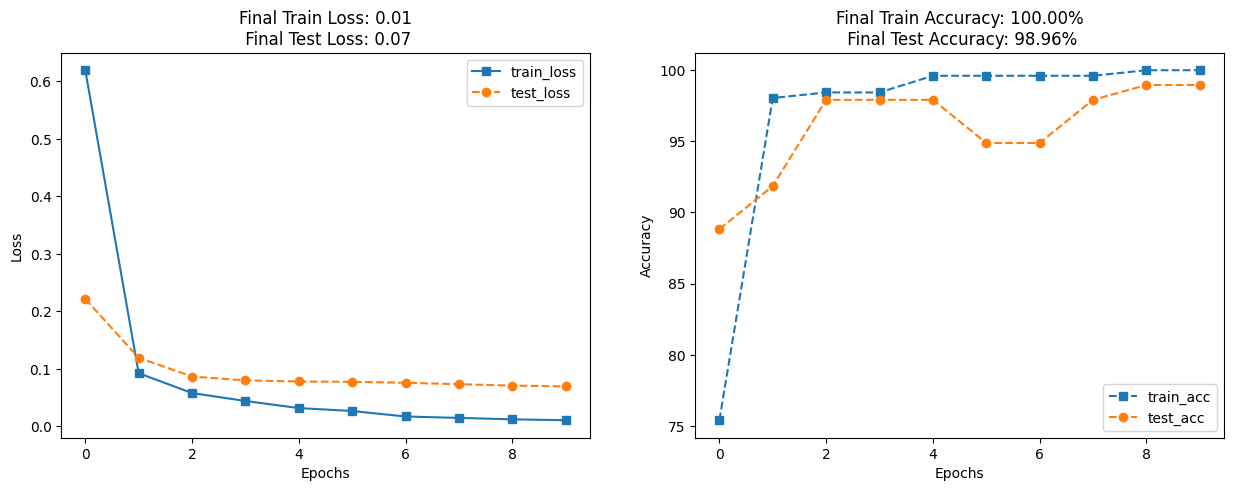

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(results["train_loss"],"s-",label="train_loss")
ax[0].plot(results["test_loss"],"o--",label="test_loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title(f"Final Train Loss: {results['train_loss'][-1]:.2f}\n Final Test Loss: {results['test_loss'][-1]:.2f}")
ax[0].legend()

ax[1].plot(results["train_acc"],"s--",label="train_acc")
ax[1].plot(results["test_acc"],"o--",label="test_acc")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title(f"Final Train Accuracy: {results['train_acc'][-1]:.2f}%\n Final Test Accuracy: {results['test_acc'][-1]:.2f}%")
ax[1].legend()
plt.show();

# Predict an image using the model

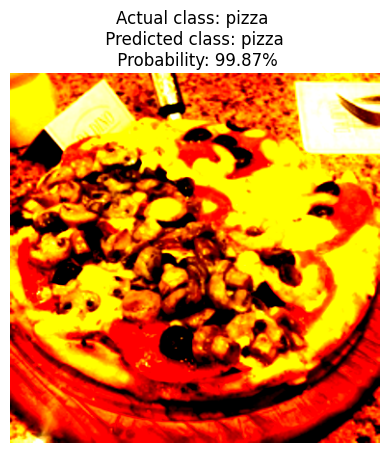

In [ ]:
# transform the image for prediction
image_transformed = transforms(image)

vit_b16_pretrained.eval()
with torch.inference_mode():
  image_pred = image_transformed.unsqueeze(0).to(device)
  pred_logits = vit_b16_pretrained(image_pred)

pred_probs = torch.softmax(pred_logits, dim=1)
pred_max_prob, pred_label = torch.max(pred_probs, dim=1)

plt.imshow(image_transformed.permute(1,2,0))
plt.title(f"Actual class: {class_names[label]} \n Predicted class: {class_names[pred_label]} \n Probability: {pred_max_prob.item() * 100:0.2f}%")
plt.axis("off")
plt.show();

# Save the model

In [ ]:
model_path = Path("/content/models")

if not os.path.exists(model_path):
  os.makedirs(model_path)

model_name = "vit_b16.pth"

torch.save(obj=vit_b16_pretrained.state_dict(),
           f=model_path / model_name)

In [ ]:
# Get the size of the model
model_size = os.path.getsize("/content/models/vit_b16.pth")
print(f"The model size is: {model_size / (1024 * 1024):.2f} MB")

The model size is: 328.48 MB


# Load the model

In [ ]:

model_path = model_path / "vit_b16.pth"

# Build the same shape model you trained
model = vit_b_16(weights=None, num_classes=len(class_names), image_size=384).to(device)

# Load checkpoint
state_dict = torch.load(model_path, map_location=device)

# --- Remap common classifier key names to torchvision's ViT head ---
key_map = {
    "head.weight": "heads.head.weight",
    "head.bias":   "heads.head.bias",
    "classifier.weight": "heads.head.weight",
    "classifier.bias":   "heads.head.bias",
    "fc.weight": "heads.head.weight",
    "fc.bias":   "heads.head.bias",
}

for old_k, new_k in list(key_map.items()):
    if old_k in state_dict and new_k not in state_dict:
        state_dict[new_k] = state_dict.pop(old_k)

# --- If the saved head doesn't match current num_classes, drop it so the layer stays randomly init ---
head_w = state_dict.get("heads.head.weight")
head_b = state_dict.get("heads.head.bias")
if head_w is not None and head_w.shape[0] != model.heads.head.out_features:
    state_dict.pop("heads.head.weight", None)
    state_dict.pop("heads.head.bias", None)
    print(f"⚠️ Dropped classifier from checkpoint "
          f"(saved: {head_w.shape[0]} classes, current: {model.heads.head.out_features}).")

# Finally load
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Loaded with:")
print("  missing_keys   :", missing)
print("  unexpected_keys:", unexpected)


Loaded with:
  missing_keys   : []
  unexpected_keys: []


# Test the model

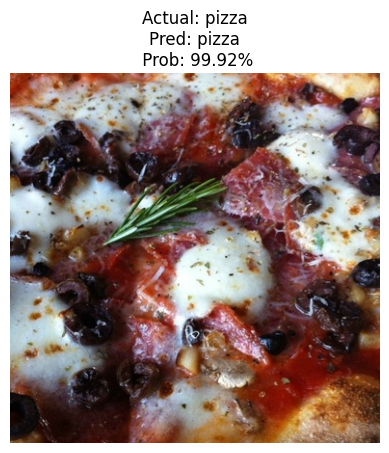

In [ ]:
from extract_mean_std import extract_mean_std

# Get one batch (already normalized by dataset.transform)
image_batch, label_batch = next(iter(test_dataloader))
idx = random.randrange(len(image_batch))
image, label = image_batch[idx], label_batch[idx]

# Run model
model.eval()
with torch.inference_mode():
    pred_logits = model(image.unsqueeze(0).to(device))
pred_probs = torch.softmax(pred_logits, dim=1)
pred_max_prob, pred_label = torch.max(pred_probs, dim=1)

# Extract normalization params once
mean, std = extract_mean_std(transforms)   # your Compose pipeline
mean_t = torch.as_tensor(mean, device=image.device).view(-1,1,1)
std_t  = torch.as_tensor(std,  device=image.device).view(-1,1,1)

# Undo normalization safely
image_unnorm = (image * std_t + mean_t).clamp(0, 1)

plt.imshow(image_unnorm.permute(1,2,0).cpu())
plt.title(f"Actual: {class_names[label.item()]}\nPred: {class_names[pred_label]}\n Prob: {pred_max_prob.item()*100:0.2f}%")
plt.axis("off")
plt.show();


# Download an image from the internet

In [ ]:
from download_image import download_image
image_to_download = random.choice(class_names)

image_path = download_image(image_to_download)

ℹ️ Attempting: Wikimedia Commons -> https://upload.wikimedia.org/wikipedia/commons/2/23/Sushi_%2825966188494%29.jpg
✅ Saved: sushi.jpg (source: Wikimedia Commons; attempts: 1)


torch.Size([3, 3840, 5760])


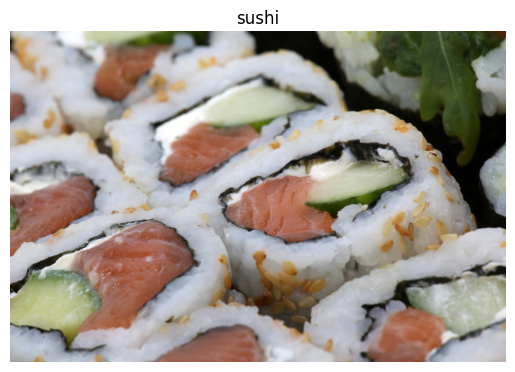

In [ ]:
from torchvision.io import read_image
image = read_image(str(image_path))
print(image.shape)
plt.imshow(image.permute(1,2,0))
plt.title(f"{image_to_download}")
plt.axis("off");

# Run the downlaoded image through the model

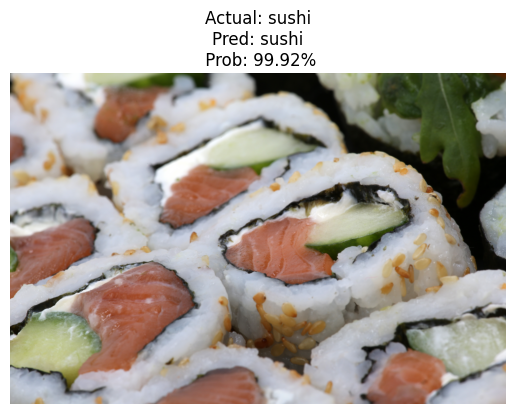

In [ ]:
image_transformed = transforms(image)

model.eval()
with torch.inference_mode():
  logits = model(image_transformed.unsqueeze(0).to(device))
pred_probs = torch.softmax(logits, dim=1)
pred_max_prob, pred_label = torch.max(pred_probs, dim=1)

plt.imshow(image.permute(1,2,0))
plt.title(f"Actual: {image_to_download}\nPred: {class_names[pred_label]}\n Prob: {pred_max_prob.item()*100:0.2f}%")
plt.axis("off")
plt.show();